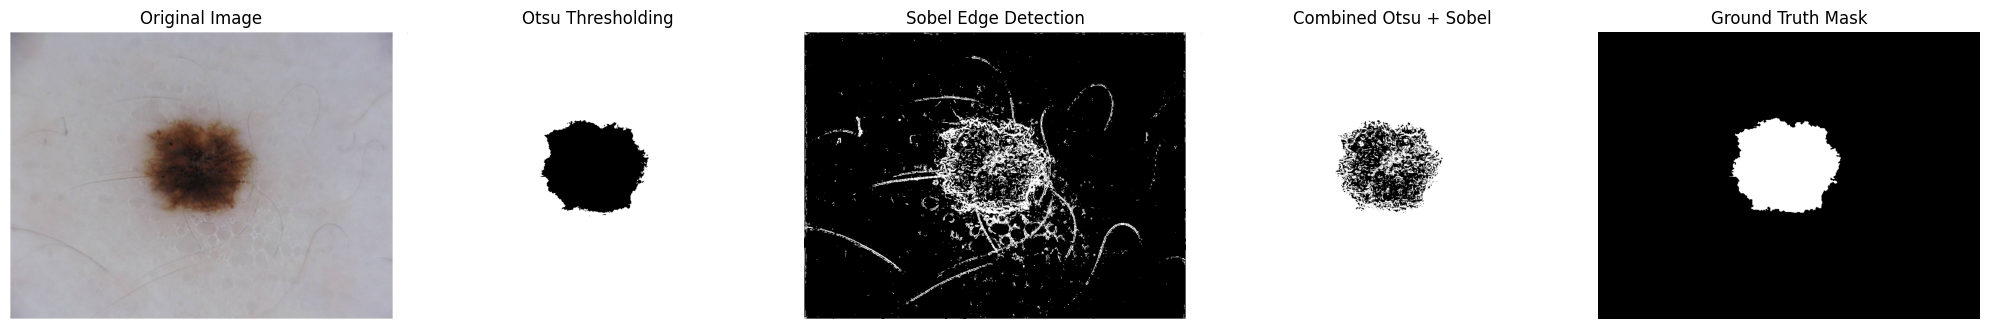

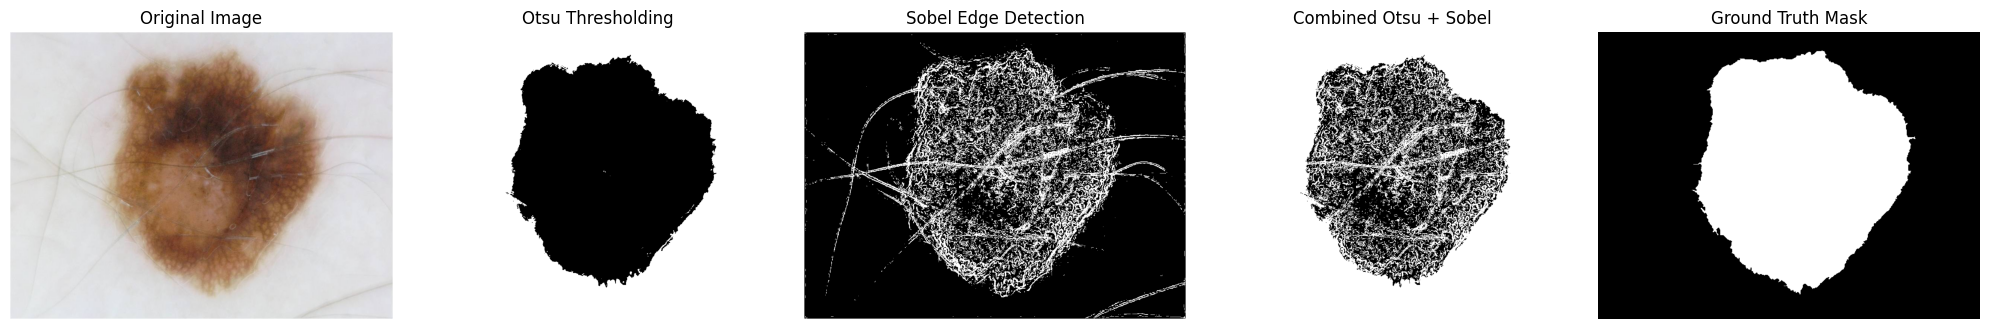

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dataset paths
train_images_dir = 'skin_dataset/ISIC2018_Task1-2_Training_Input'
train_masks_dir = 'skin_dataset/ISIC2018_Task1_Training_GroundTruth'

def load_image_and_mask(image_id):
    image_path = os.path.join(train_images_dir, f"{image_id}.jpg")
    mask_path = os.path.join(train_masks_dir, f"{image_id}_segmentation.png")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    return image, mask

def apply_otsu_sobel(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Sobel Edge Detection
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobel_x, sobel_y)
    sobel_edges = np.uint8(sobel_edges / sobel_edges.max() * 255)

    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    _, sobel_uint8 = cv2.threshold(sobel_magnitude.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    combined = cv2.bitwise_or(otsu_thresh, sobel_uint8)

    return otsu_thresh, sobel_uint8, combined

def visualize_results(image, otsu, sobel, combined, mask):
    """
    Visualize the original image, Otsu thresholding, Sobel edges, and their combination.
    """
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(otsu, cmap='gray')
    plt.title("Otsu Thresholding")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(sobel, cmap='gray')
    plt.title("Sobel Edge Detection")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(combined, cmap='gray')
    plt.title("Combined Otsu + Sobel")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_id = 'ISIC_0000001'  # Replace with any image ID from the dataset
image, mask = load_image_and_mask(image_id)
otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)

visualize_results(image, otsu_thresh, sobel_edges, combined, mask)

image_id = 'ISIC_0000003'  # Replace with any image ID from the dataset
image, mask = load_image_and_mask(image_id)
otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)
visualize_results(image, otsu_thresh, sobel_edges, combined, mask)


In [2]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_normalized = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    sobel_uint8 = sobel_normalized.astype(np.uint8)
    
    otsu_norm = otsu_thresh / 255.0
    sobel_norm = sobel_uint8 / 255.0
    combined = np.stack((otsu_norm, sobel_norm), axis=-1)
    
    return combined

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-17 07:13:52.416465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737090832.496683  134320 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737090832.522011  134320 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 07:13:52.717067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256), max_num=0):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        if max_num == 0: break
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_segmentation.png'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            # Preprocess the image
            processed_image = preprocess_image(image)

            images.append(processed_image)
            masks.append(mask / 255.0)  # Normalize mask
            max_num -= 1

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

In [5]:

def build_unet(input_shape=(256, 256, 2)):
    inputs = layers.Input(shape=input_shape)
    
    # Simplified Convolutional Block
    def conv_block(x, filters, dropout_rate=0.1):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)  # Dropout for regularization
        return x

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)

    # Decoder
    u4 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = conv_block(u4, 64)

    u5 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = conv_block(u5, 32)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

In [12]:
X, Y = load_and_preprocess_data(train_images_dir, train_masks_dir, max_num=500)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │        608 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ dropout_5[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_15[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │     32,832 │ dropout_7[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_18[0][0] 

 Total params: 466,241 (1.78 MB)

 Trainable params: 466,241 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model based on validation loss
checkpoint = ModelCheckpoint("best_light_unet.h5", monitor='val_loss', save_best_only=True)

# Stop training early if validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train with callbacks
history = model.fit(X_train, Y_train, 
                     epochs=50, 
                     batch_size=16, 
                     validation_split=0.1, 
                     callbacks=[checkpoint, early_stop])


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7164 - loss: 0.5542

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.7193 - loss: 0.5515 - val_accuracy: 0.8174 - val_loss: 0.4580
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8404 - loss: 0.4042 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8403 - loss: 0.4041 - val_accuracy: 0.8239 - val_loss: 0.4182
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8378 - loss: 0.3867 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8382 - loss: 0.3858 - val_accuracy: 0.8360 - val_loss: 0.3908
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8630 - loss: 0.3281 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8627 - loss: 0.3286 - val_accuracy: 0.8546 - val_loss: 0.3562
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8650 - loss: 0.3319 - val_accuracy: 0.8333 - val_loss: 0.3977
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8469 - loss: 0.3649 - val_accuracy: 0.8567 - val_loss: 0.3904
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8827 - loss: 0.3200 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8829 - loss: 0.3194 - val_accuracy: 0.8752 - val_loss: 0.3307
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8894 - loss: 0.2976 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8898 - loss: 0.2968 - val_accuracy: 0.8786 - val_loss: 0.3199
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9067 - loss: 0.2589 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9066 - loss: 0.2593 - val_accuracy: 0.8840 - val_loss: 0.3099
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9069 - loss: 0.2576 - val_accuracy: 0.8826 - val_loss: 0.3182
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9072 - loss: 0.2592 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9071 - loss: 0.2597 - val_accuracy: 0.8875 - val_loss: 0.2957
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9193 - loss: 0.2220

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9189 - loss: 0.2232 - val_accuracy: 0.8868 - val_loss: 0.2928
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9055 - loss: 0.2579 - val_accuracy: 0.8887 - val_loss: 0.2944
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9029 - loss: 0.2611 - val_accuracy: 0.8805 - val_loss: 0.3115
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9087 - loss: 0.2503 - val_accuracy: 0.8729 - val_loss: 0.3336
Epoch 16/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9140 - loss: 0.2324 - val_accuracy: 0.8878 - val_loss: 0.2959
Epoch 17/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9121 - loss: 0.2500

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9122 - loss: 0.2497 - val_accuracy: 0.8853 - val_loss: 0.2927
Epoch 18/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9151 - loss: 0.2336

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9150 - loss: 0.2338 - val_accuracy: 0.8912 - val_loss: 0.2803
Epoch 19/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9144 - loss: 0.2271 - val_accuracy: 0.8813 - val_loss: 0.2967
Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9137 - loss: 0.2352 - val_accuracy: 0.8938 - val_loss: 0.2888
Epoch 21/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9115 - loss: 0.2453 - val_accuracy: 0.8950 - val_loss: 0.2887
Epoch 22/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9190 - loss: 0.2208 - val_accuracy: 0.8958 - val_loss: 0.2963
Epoch 23/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9183 - loss: 0.2265 - val_accuracy: 0.8899 - val_loss: 0.2954


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


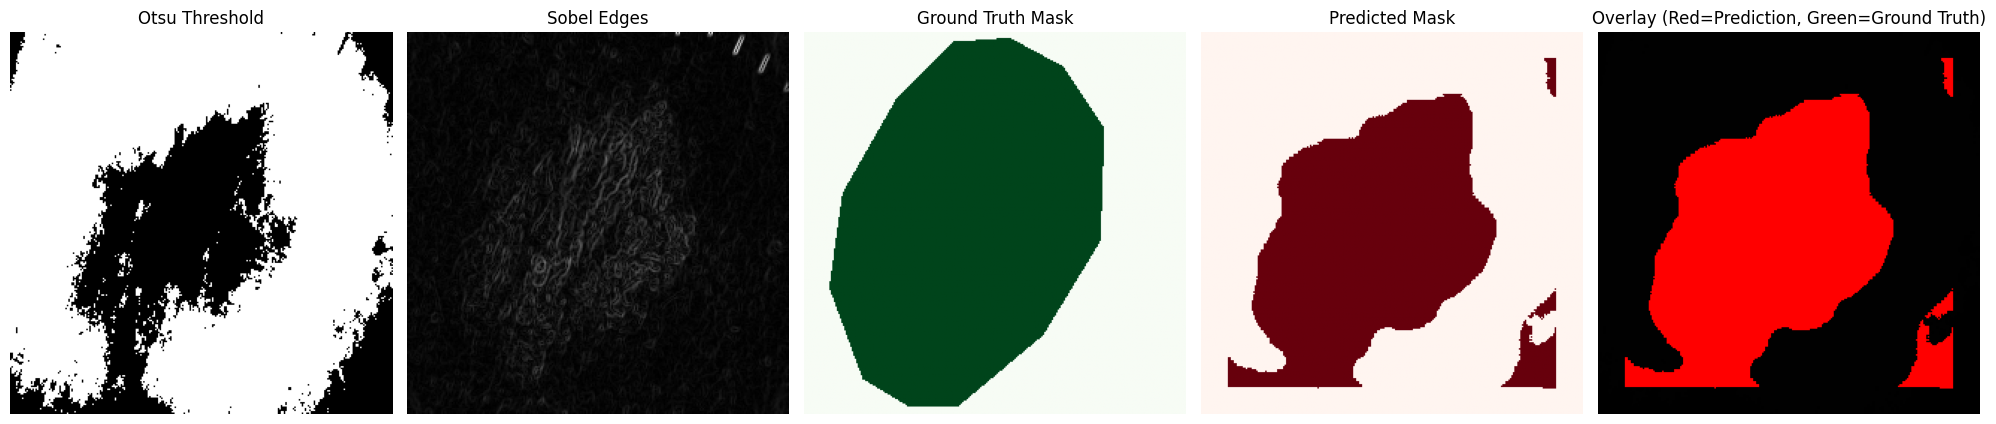

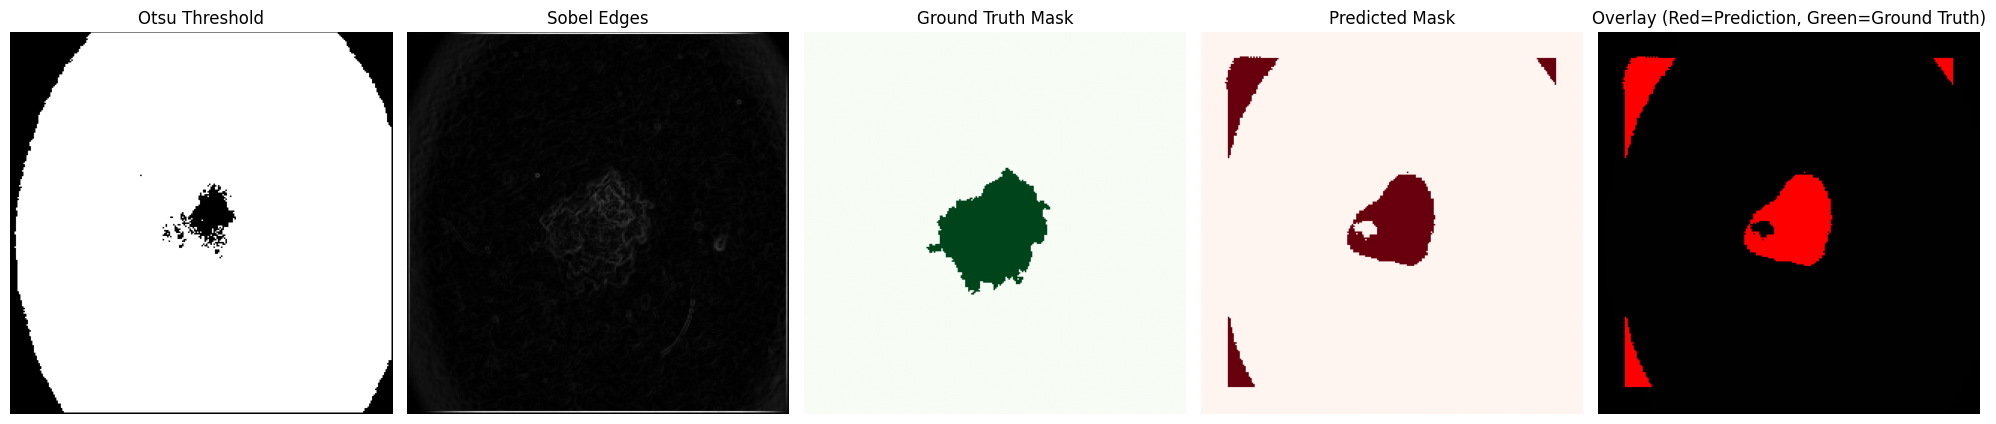

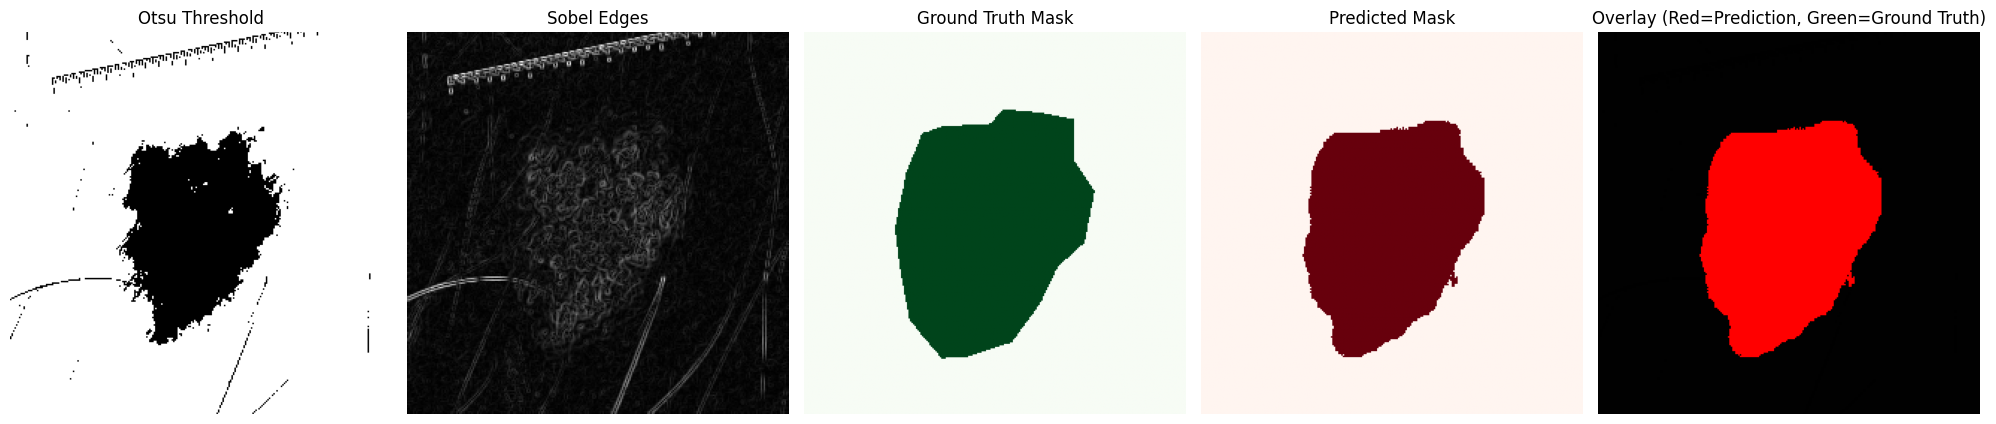

In [14]:
def plot_predictions_with_mask(model, X, Y, threshold=0.5, num_samples=3):
    preds = model.predict(X[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(20, 5))

        # Original Image (Otsu channel)
        plt.subplot(1, 5, 1)
        plt.imshow(X[i][:, :, 0], cmap='gray')
        plt.title('Otsu Threshold')
        plt.axis('off')

        # Sobel Edges
        plt.subplot(1, 5, 2)
        plt.imshow(X[i][:, :, 1], cmap='gray')
        plt.title('Sobel Edges')
        plt.axis('off')

        # Ground Truth Mask (Normalized to 0-1)
        plt.subplot(1, 5, 3)
        normalized_gt_mask = (Y[i].squeeze() / 255.0)  # Normalize ground truth to 0-1
        plt.imshow(normalized_gt_mask, cmap='Greens')  # Green for ground truth
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask (Thresholded)
        plt.subplot(1, 5, 4)
        predicted_mask = (preds[i].squeeze() > threshold).astype(np.uint8)
        plt.imshow(predicted_mask, cmap='Reds')  # Red for predictions
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay of Prediction on Original Image
        plt.subplot(1, 5, 5)
        overlay = X[i][:, :, 0].copy()
        overlay = np.stack([overlay]*3, axis=-1)  # Convert grayscale to RGB
        overlay[predicted_mask == 1] = [255, 0, 0]  # Red overlay for prediction
        overlay[normalized_gt_mask == 1] = [0, 255, 0]  # Green overlay for ground truth
        plt.imshow(overlay.astype(np.uint8))
        plt.title('Overlay (Red=Prediction, Green=Ground Truth)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


plot_predictions_with_mask(model, X_val, Y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


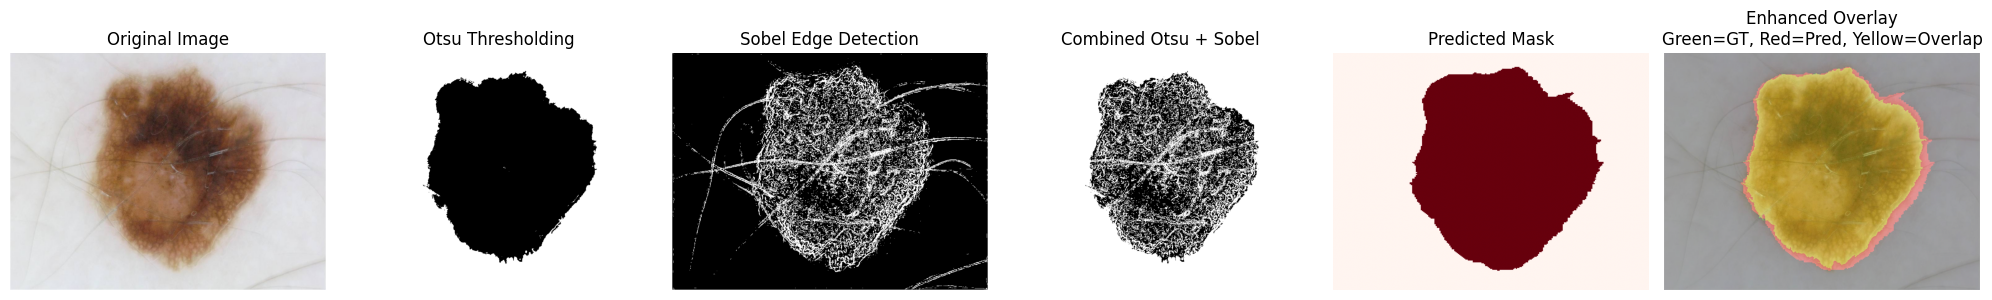

In [15]:

def load_single_image_and_mask(image_id, dataset='train'):
    if dataset == 'train':
        image_dir = 'skin_dataset/ISIC2018_Task1-2_Training_Input'
        mask_dir = 'skin_dataset/ISIC2018_Task1_Training_GroundTruth'
        mask_path = os.path.join(mask_dir, f"{image_id}_segmentation.png")
    else:
        image_dir = 'skin_dataset/ISIC2018_Task1-2_Test_Input'
        mask_path = None  # Test set usually doesn't have ground truth

    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load mask if available
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path and os.path.exists(mask_path) else None
    
    return image, mask

def visualize_image_with_segmentation_intersection(model, image_id, dataset='train', threshold=0.5):
    # Load image and ground truth mask
    image, mask = load_single_image_and_mask(image_id, dataset)

    # Apply preprocessing (Otsu + Sobel)
    otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)

    # Prepare input for model prediction
    combined_input = np.stack((otsu_thresh / 255.0, sobel_edges / 255.0), axis=-1)
    combined_input = cv2.resize(combined_input, (256, 256))
    combined_input = np.expand_dims(combined_input, axis=0)  # Add batch dimension

    # Predict mask
    pred_mask = model.predict(combined_input)[0, :, :, 0]
    pred_mask = (pred_mask > threshold).astype(np.uint8)

    # Resize prediction back to original image size
    pred_mask_resized = cv2.resize(pred_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create color overlay: Green (GT), Red (Predicted), Yellow (Overlap)
    overlay = image.copy()
    overlay_mask = np.zeros_like(overlay)

    if mask is not None:
        gt_binary = (mask == 255).astype(np.uint8)
        pred_binary = pred_mask_resized

        # True Positives (Overlap) → Yellow
        intersection = (gt_binary & pred_binary).astype(bool)
        overlay_mask[intersection] = [255, 255, 0]  # Yellow

        # Ground Truth only → Green
        gt_only = (gt_binary == 1) & (pred_binary == 0)
        overlay_mask[gt_only] = [0, 255, 0]  # Green

        # Prediction only → Red
        pred_only = (pred_binary == 1) & (gt_binary == 0)
        overlay_mask[pred_only] = [255, 0, 0]  # Red

    # Blend with transparency
    blended_overlay = cv2.addWeighted(overlay, 0.7, overlay_mask, 0.3, 0)

    # Visualization
    plt.figure(figsize=(20, 6))

    # 1. Original Image
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 2. Otsu Thresholding
    plt.subplot(1, 6, 2)
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title('Otsu Thresholding')
    plt.axis('off')

    # 3. Sobel Edge Detection
    plt.subplot(1, 6, 3)
    plt.imshow(sobel_edges, cmap='gray')
    plt.title('Sobel Edge Detection')
    plt.axis('off')

    # 4. Combined Otsu + Sobel
    plt.subplot(1, 6, 4)
    plt.imshow(combined, cmap='gray')
    plt.title('Combined Otsu + Sobel')
    plt.axis('off')

    # 5. Predicted Mask
    plt.subplot(1, 6, 5)
    plt.imshow(pred_mask_resized, cmap='Reds')
    plt.title('Predicted Mask')
    plt.axis('off')

    # 6. Enhanced Overlay (GT, Prediction, Intersection)
    plt.subplot(1, 6, 6)
    plt.imshow(blended_overlay)
    plt.title('Enhanced Overlay\nGreen=GT, Red=Pred, Yellow=Overlap')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
visualize_image_with_segmentation_intersection(model, image_id='ISIC_0000003', dataset='train')
